# Preprocessing
Converts the given datasets to obtain the dataset with binary masks annotations in the form R^{h×w×q}.

## Datasets

### DSB2018
The Data Science Bowl 2018 dataset is taken from the following sources:
- `DSB2018_train` **(664 images)**: version with fixed training masks from [lopuhin/kaggle-dsbowl-2018-dataset-fixes](https://github.com/lopuhin/kaggle-dsbowl-2018-dataset-fixes). These corrected annotations were used by the competition's best solutions. 
- `DSB2018_test1` **(65 images)**: `stage1_test` images were included from [yuanqing811/DSB2018_stage1_test](https://github.com/yuanqing811/DSB2018_stage1_test), who converted the file `stage1_solutions.csv`.
- `DSB2018_test2` **(3019 images)**: `stage2_test_final` masks can be found at the Broad Institute's [Kaggle 2018 Data Science Bowl](https://bbbc.broadinstitute.org/BBBC038) page. Masks are converted by applying an adapted version of yuanqing811's algorithm

### NSDE
The NucleusSegData extended **(61 images)** is available at [https://mysite.ku.edu.tr/cgunduz/downloads/nucleussegdata/](https://mysite.ku.edu.tr/cgunduz/downloads/nucleussegdata/).

### BBBC039
The [Nuclei of U2OS cells in a chemical screen](https://bbbc.broadinstitute.org/BBBBC039) dataset **(200 images)** available from the Broad Institute contains some images already present in the `DSB2018_test2` dataset.

Starts with 3686 images.

# Parameters and initialization
Imports libraries and specifies the paths of datasets (already unzipped).

In [ ]:
import os
import shutil
from distutils.dir_util import copy_tree
from PIL import Image
import json

import cv2
import numpy as np
import pandas as pd
import math
from skimage.metrics import structural_similarity as ssim
import skimage.io
import skimage.morphology
import random

import matplotlib.pyplot as plt
from pprint import pprint

random.seed(42)

In [2]:
# Working directory where to find original datasets, and where new datasets will be saved
base_dir = "path/to/datasets"

# Subfolder with original datasets
original_subfolder = "0_original_ds"

# Name of file containing dataset information
json_ds_info = "ds_info.json"

# Name of dataset with fixed training masks
dsb2018_train_name = "stage1_train"

# Name of dataset with test images and files
dsb2018_test1_name = "stage1_test"

# Name of dataset with test (phase 2) images and files
dsb2018_test2_name = "stage2_test_final"

# Stage2_test solution file
test2_solutions_name = "stage2_solution_final.csv"

# Pre-preprocessed test2 images
dsb2018_test2_masked_name = "stage2_test_final_masked"

# Name of the dataset with NSDE files
nsde_name = "NucleusSegDataExtended"

# Name of the BBBC039 dataset
bbbc039_name = "broadinstitute_BBBC039"

# Folder for relevant images converted to the DSB format
dsb_format_folder = "dsb_format_dataset" 

In [ ]:
def create_folder(folder):
	"""Deletes a folder if it exists, then creates it"""
	if os.path.exists(folder) and os.path.isdir(folder):
		shutil.rmtree(folder)
	os.makedirs(folder)

# DSB2018-specific preprocessing
Computes and saves the masks of annotated images in `DSB2018_test2`.

In [3]:
# Adapted from https://github.com/yuanqing811/DSB2018_stage1_test
def get_test_image_by_id(src_dir, img_id):
	img_path = os.path.join(src_dir, img_id, 'images', '%s.png' % img_id)
	try:
		return cv2.imread(img_path)[:, :, :3]
	except:
		return cv2.imread(img_path)

def rle_decode(rle_list, mask_shape, mask_dtype):
	mask = np.zeros(np.prod(mask_shape), dtype=mask_dtype)
	for j, rle in enumerate(rle_list):
		s = rle.split()
		starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
		starts -= 1
		ends = starts + lengths
		for lo, hi in zip(starts, ends):
			mask[lo:hi] = (j+1)

	return mask.reshape(mask_shape[::-1]).T

def decode_submission(src_dir, dst_dir, solution_filename):
	df = pd.read_csv(os.path.join(src_dir, solution_filename), sep=',')
	test_id_list = sorted([test_id for test_id in os.listdir(src_dir) if not test_id.startswith('.') and not test_id.endswith('.csv')])

	test_len = len(test_id_list)
	for i, test_id in enumerate(test_id_list, start=1):
		mask_rles = df.loc[df['ImageId'] == test_id]
		if "Ignored" in mask_rles["Usage"].tolist():
			# stage2_test_final dummy images are not considered
			continue
		
		img = get_test_image_by_id(src_dir, test_id)
		rows, cols = img.shape[0], img.shape[1]
		print(f"Converting {i}/{test_len}                 ", end='\r')

		mask = rle_decode(rle_list=mask_rles['EncodedPixels'], mask_shape=(rows, cols), mask_dtype=np.uint8)
		num_masks = np.max(mask)

		image_dir = dst_dir + '/' + test_id + '/images/'
		os.makedirs(image_dir, exist_ok=True)
		shutil.copyfile(os.path.join(src_dir, test_id, 'images', test_id + '.png'), os.path.join(image_dir, test_id + '.png'))

		mask_dir = dst_dir + '/' + test_id + '/masks/'
		os.makedirs(mask_dir, exist_ok=True)
		for i_mask in range(num_masks):
			c_mask = 255 * (mask == (i_mask + 1))
			mask_img_string = test_id + '_' + str(i_mask) + '.png'
			im = Image.fromarray(np.asarray(c_mask, dtype=np.uint8))
			im.save(mask_dir + mask_img_string)

In [4]:
test2_path = os.path.join(base_dir, original_subfolder, dsb2018_test2_name)
masked_test2_path = os.path.join(base_dir, original_subfolder, dsb2018_test2_masked_name)
create_folder(masked_test2_path)
decode_submission(test2_path, masked_test2_path, test2_solutions_name)
print(f"\nKept {len(os.listdir(masked_test2_path))}/{len(os.listdir(test2_path)) - 1} images")

Converting 3014/3019                 
Kept 106/3019 images


The Data Science Bowl provided a dataset with 3 types of images, therefore selects only the ones obtained from fluorescence microscopy.

Other images either
- Are not grayscale
- Have a much higher average pixel value

Starts by copying all grayscale images to the new folder.

In [5]:
def is_grayscale(image):
	"""Checks if an image is grayscale by comparing its channels"""
	if len(image.shape) < 3 or image.shape[2] == 1:
		# If the image has only one channel, it is grayscale
		return True
	# Otherwise, compare channels and return True if they are all equal
	return (image[:, :, 0] == image[:, :, 1]).all() and (image[:, :, 1] == image[:, :, 2]).all()

In [6]:
def copy_grayscale(dataset_name):
	"""Copies only grayscale images to the dsb_format_folder"""
	# Folder where to find images
	origin_dir = os.path.join(base_dir, original_subfolder, dataset_name)
	destination_dir = os.path.join(base_dir, dsb_format_folder, dataset_name)

	for image_id in os.listdir(origin_dir):
		image_path = os.path.join(origin_dir, image_id, "images", image_id + ".png")
		image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
		if is_grayscale(image):
			copy_tree(os.path.join(origin_dir, image_id), os.path.join(destination_dir, image_id))	

In [6]:
dsb_path = os.path.join(base_dir, dsb_format_folder)
dsb_train_path = os.path.join(dsb_path, dsb2018_train_name)
dsb_test1_path = os.path.join(dsb_path, dsb2018_test1_name)
dsb_test2_path = os.path.join(dsb_path, dsb2018_test2_masked_name)

In [8]:
create_folder(dsb_path)

create_folder(dsb_train_path)
copy_grayscale(dsb2018_train_name)

create_folder(dsb_test1_path)
copy_grayscale(dsb2018_test1_name)

create_folder(dsb_test2_path)
copy_grayscale(dsb2018_test2_masked_name)

Created folder C:/Users/rober/Desktop/datasets/1_dsb_format_reduced\stage1_train
Created folder C:/Users/rober/Desktop/datasets/1_dsb_format_reduced\stage1_test
Created folder C:/Users/rober/Desktop/datasets/1_dsb_format_reduced\stage2_test_final_masked


Looks for a threshold on the pixel mean of all the copied files.

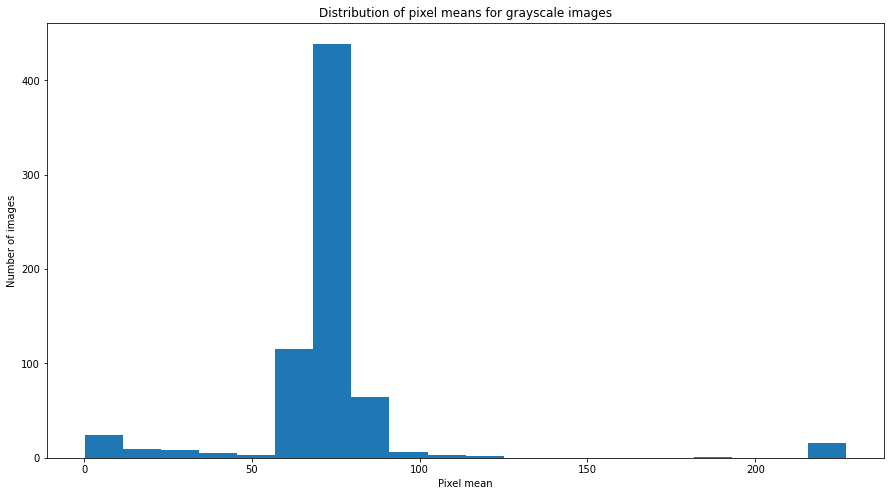

In [9]:
pixel_means = []
for folder in os.listdir(dsb_path):
	for image_id in os.listdir(os.path.join(dsb_path, folder)):
			image_path = os.path.join(dsb_path, folder, image_id, "images", image_id + ".png")
			image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
			pixel_means.append(np.mean(image))

plt.figure(figsize=(15,8))
plt.hist(pixel_means, bins=20)
plt.xlabel("Pixel mean")
plt.ylabel("Number of images")
plt.title("Distribution of pixel means for grayscale images")
plt.show()

Removes bright images by setting a threshold of 150. 

In [19]:
dsb_fluorescence_threshold = 150

In [11]:
for folder in os.listdir(dsb_path):
	for image_id in os.listdir(os.path.join(dsb_path, folder)):
			image_path = os.path.join(dsb_path, folder, image_id, "images", image_id + ".png")
			image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
			if np.mean(image) > dsb_fluorescence_threshold:
				shutil.rmtree(os.path.join(dsb_path, folder, image_id))

# NSDE-specific preprocessing
Converts annotations from the .gold format and converts images to grayscale.

In [12]:
def convert_nsde_to_dsb(dataset_folder, prefix):
	"""Converts images from the NSDE format to the DSB2018"""
	origin_dir = os.path.join(base_dir, original_subfolder, nsde_name, dataset_folder)
	destination_dir = os.path.join(base_dir, dsb_format_folder, nsde_name)
	
	# Here I exploit the regularity in file names (prefix_n.(jpg|gold)) to avoid
	# cycling on files
	total = math.floor(len(os.listdir(origin_dir)) / 2)
	for image_i in range(1, total + 1):
		print(f"{dataset_folder}: converting image {image_i}/{total}                               ", end='\r')

		# Create folders for the dsb format
		id = prefix + str(image_i)
		new_img_path = os.path.join(destination_dir, id)
		create_folder(new_img_path)
		create_folder(os.path.join(new_img_path, "images"))
		create_folder(os.path.join(new_img_path, "masks"))
		
		# Convert to grayscale and save the base image (as RGB to comply with the network)
		Image.open(os.path.join(origin_dir, id + ".jpg")).convert("L").convert("RGB").save(os.path.join(new_img_path, "images", id + ".png"))

		# Convert the .gold file
		with open(os.path.join(origin_dir, id + ".gold"), "r") as mask_file:
			# The first row contains the image row×columns
			mask_shape = []
			for d in mask_file.readline().split(" "):
				mask_shape.append(int(d))

			# Compute the mask
			mask = np.zeros(mask_shape)
			row = 0
			for line in mask_file.readlines():
				column = 0
				for pixel in line.split(" "):
					try:
						mask[row][column] = int(pixel)
					except ValueError:
						# Ignore the \n
						pass
					column += 1
				row += 1

			# Save all the image's masks
			for mask_id in range(1, int(np.max(mask)) + 1):
				Image.fromarray(np.where(mask == mask_id, 255, 0)).convert("RGB").save(os.path.join(new_img_path, "masks", id + "_" + str(mask_id) + ".png"))
	print()

create_folder(os.path.join(base_dir, dsb_format_folder, nsde_name))
convert_nsde_to_dsb("TrainingSet", "tr")
convert_nsde_to_dsb("HepG2TestSet", "hepg2_ts")
convert_nsde_to_dsb("Huh7TestSet", "huh7_ts")

TrainingSet: converting image 25/25                               
HepG2TestSet: converting image 25/25                               
Huh7TestSet: converting image 11/11                               


# BBBC039-specific preprocessing
These images are potentially duplicates of the Data Science Bowl's. Masks need also to be converted in the DSB format. 

Images are normalized as well

In [3]:
bbbc039_images_path = os.path.join(base_dir, original_subfolder, bbbc039_name, "images")
bbbc039_masks_path = os.path.join(base_dir, original_subfolder, bbbc039_name, "masks")

In [21]:
# Adapted from https://pyimagesearch.com/2014/09/15/python-compare-two-images/

def mse(imageA, imageB):
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	return err

def compare_images(imageA, imageB):
	if imageA.shape != imageB.shape:
		return False

	# Compare normalized
	min_1 = np.min(imageA)
	max_1 = np.max(imageA)
	if min_1 != max_1:
		imageA = ((imageA - min_1) / (max_1 - min_1))
	min_2 = np.min(imageB)
	max_2 = np.max(imageB)
	if min_2 != max_2:
		imageB = ((imageB - min_2) / (max_2 - min_2))
		
	# Return true if images are similar
	return mse(imageA, imageB) < 0.02 and ssim(imageA, imageB) > 0.98

In [22]:
bbc_convert_path = os.path.join(base_dir, dsb_format_folder, bbbc039_name)
create_folder(bbc_convert_path)

# Preloading all bbbc039 image sto speed up check
bbbc039_images = {}
bbc_len = len(os.listdir(bbbc039_images_path))
for i, image in enumerate(os.listdir(bbbc039_images_path), start=1):
	print(f"Loading image {i}/{bbc_len}", end='\r')
	bbbc039_images[image] = cv2.imread(os.path.join(bbbc039_images_path, image), cv2.IMREAD_UNCHANGED)

bbc_id_list = list(bbbc039_images.keys())
bbc_len = len(bbbc039_images)
for path in [dsb_train_path, dsb_test1_path, dsb_test2_path]:
	print("Comparing with", path)
	
	path_content = os.listdir(os.path.join(path))
	len_content = len(path_content)
	for c_i, id in enumerate(path_content, start=1):
		image = cv2.imread(os.path.join(path, id, "images", id + ".png"), cv2.IMREAD_GRAYSCALE)
		for bbc_i, bbc in enumerate(bbc_id_list, start=1):
			if bbc in bbbc039_images:
				print(f"Analyzing {c_i}/{len_content}: {bbc_i}/{bbc_len}                    ", end='\r')
				if compare_images(image, bbbc039_images[bbc]):
					# Can avoid further checks on the image
					del bbbc039_images[bbc]
					continue
	print()
	
print(f"\nKept {len(bbbc039_images)}/{bbc_len} images")

Comparing with C:/Users/rober/Desktop/datasets/1_dsb_format_reduced\stage1_train
Analyzing 541/541: 200/200                    
Comparing with C:/Users/rober/Desktop/datasets/1_dsb_format_reduced\stage1_test
Analyzing 53/53: 200/200                    
Comparing with C:/Users/rober/Desktop/datasets/1_dsb_format_reduced\stage2_test_final_masked
Analyzing 84/84: 200/200                    

Kept 157/200 images


In [16]:
# Adapted from https://gist.github.com/jccaicedo/15e811722fca51e3ae90e8b43057f075
def save_masks(mask_path, mask_name, destination_path):
	gt = skimage.io.imread(os.path.join(mask_path, mask_name))
	# Keep first channel only
	gt = gt[:,:,0]
	# Label independent connected components
	gt = skimage.morphology.label(gt)

	gt_id = mask_name.split('.')[0]
	for color in range(1, np.max(gt) + 1):
		mask = np.where(gt == color, 255, 0)
		Image.fromarray(mask).convert('RGB').save(os.path.join(destination_path, gt_id + "_" + str(color) + ".png"))
	return np.max(gt)

In [17]:
total = len(bbbc039_images)
for i, item in enumerate(bbbc039_images.items(), start=1):
	image_name, image = item
	print(f"Converting image {i}/{total}        ", end='\r')
	new_path = os.path.join(base_dir, dsb_format_folder, bbbc039_name)
	image_id = image_name.split('.')[0]
	png_image = image_id + ".png"

	# Create the new folders
	image_path = os.path.join(new_path, image_id, "images")
	masks_path = os.path.join(new_path, image_id, "masks")
	create_folder(image_path)
	create_folder(masks_path)

	# Save the images image	
	Image.open(os.path.join(bbbc039_images_path, image_name)).save(os.path.join(image_path, png_image))
	n_saved = save_masks(bbbc039_masks_path, png_image, masks_path)
	if n_saved == 0:
		# The image was empty, removed
		shutil.rmtree(os.path.join(new_path, image_id))
		print(f"\nImage {image_name} contained no masks, removed.")

Converting image 60/157        
Image IXMtest_F13_s7_w13C1B1D8C-293E-454F-B0FD-6C2C3F9F5173.tif contained no masks, removed.
Converting image 111/157        
Image IXMtest_L01_s2_w1E5038251-DBA3-44D0-BC37-E43E2FC8C174.tif contained no masks, removed.
Converting image 116/157        
Image IXMtest_L10_s6_w12D12D64C-2639-4CA8-9BB4-99F92C9B7068.tif contained no masks, removed.


After these steps, we have:
- `DSB2018_train`: 541 images
- `DSB2018_test1`: 53 images
- `DSB2018_test2`: 84 images
- `NSDE`: 61 images
- `BBBC039`: 157 images

For a total of 896 images.